### 一、导入工具包

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 二、数据预处理

数据文件是台中国台湾省（2014/1/1~2014/12/20）的空气质量监测数据，一共涉及18个空气质量指标，共240天24小时的数据。为了避免乱码问题，首先删除训练集源文件的前两列：日期列和“代”列（源文件标号为“代”，该列数据都是汉字伦）,并使用gbk编码打开。

In [231]:
def load_from_csv(data_path):
    '''
        @param: data_path csv文件路径
        @return:(x,y)训练数据二元组
            x:包含去除PM2.5指标剩余的17个指标。
              按列存储，即每一列表示一个时间的17个指标的样本，按照时间顺序依次排列（第1列数据
              是2014/1/1 0时数据，第2列是214/1/1 1时数据，依次类推）。
            y:对应时刻的PM2.5值
    '''
    # 指定第一行为列索引，第一列为行索引，将RAINFLALL所在行NR替换为NAN
    df = pd.read_csv(data_path, header=0, index_col=0, na_values='NR', 
                 encoding='gbk')
    
    # 将NaN替换为0
    df = df.fillna(0)
    y = df.loc['PM2.5'].values
    y = y.reshape(1,-1)
    
    df = df.drop(index='PM2.5')
    
    # 计算一个有多少天的数据
    days = df.shape[0] // 17
    
    x = df.values
    x = np.concatenate(np.vsplit(x, days), axis=1)
    
    return (x,y)

# data_path = 'data/train.csv'

In [232]:
# 测试数据加载函数
data_path = 'data/train.csv'
x,y = load_from_csv(data_path)
print('the shape of x:',x.shape)
print('the shape of y:',y.shape)

the shape of x: (17, 5760)
the shape of y: (1, 5760)


In [233]:
def normalization(data):
    '''
        采用z-score标准化数据
        @param:
            需要标准化的数据，numpy.ndarray类型
        @return:
            归一化后的数据和均值、标准差
    '''
    mu = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1 ,keepdims=True)
    data = (data - mu) / std
    return data, mu, std

In [234]:
# 测试normalization函数
x = normalization(x)
y = normalization(y)


In [235]:
def initialize_parameter(dim):
    '''
    初始化参数
        @param:
            参数的维度信息
        @return:
            随机初始化后的参数
    '''
    w = np.random.randn(1,dim)
    b = np.zeros((1,1))
    return w,b

In [236]:
# 测试参数初始化函数
w,b = initialize_parameter(17)

### 三、训练模型

线性模型的为
$$\hat{y} = \sum_i w_i \cdot x_i + b$$

衡量模型优劣的代价函数（Loss Function）为 Mean Square Error
$$L(y, \hat{y}) = \frac{1}{2} \sum_k (\hat{y}_k - y_k)^2$$

采用梯度下降法（Gradient Descent）求解
$$\frac{\partial L}{\partial w_i } = (\hat{y}_k - y_k) x_i$$

In [237]:
def get_batch(index, batch_size, X, Y):
    x = None
    y = None
    j = index + batch_size
    if j <= X.shape[1]:
        pass
    elif index < X.shape[1]:
        j = X.shape[1]
    else:
        return None, None, None
    
    x = X[:, index : j]
    y = Y[:, index : j]
    index = j
    return x, y, index
        

In [238]:
a,b,c = get_batch(0, 30000,x,y)
print(a.shape,b.shape,c)

AttributeError: 'tuple' object has no attribute 'shape'

In [261]:
def train(w, b, X, Y, alpha=0.005, iteration=100, batch_size=252):
    '''
    训练模型
        @param:
            模型参数w、b，训练数据X，Y。学习速率alpha，迭代次数iteration，batch size
        @return:
            返回训练好的参数w、b
    
    '''
    losses = []
    
    for _ in range(iteration):
        cur_index = 0
        while True:
            x, y, cur_index = get_batch(cur_index, batch_size, X, Y)
            if x is None:
                break
            
            y_ = np.dot(w, x) + b
            m = y_.shape[1]
            
            diff = y_ - y
            loss = 0.5 * np.sum(diff**2)
            losses.append(loss)
            
            dw = 1/m * np.dot(diff, x.T)
            db = 1/m * np.sum(diff, keepdims=True)
            
            w = w - alpha * dw
            b = b - alpha * db

            
#     plt.plot(losses)
#     plt.xlabel('batch iteration times')
#     plt.ylabel('loss')
#     plt.show()
    
    print('after %d iterations with the batch size %d and learning rate %f,\
the final loss is %.2f'%(iteration, batch_size, alpha, losses[-1]))
    return w,b

### 四、验证模型

首先需要对test.csv进行预处理，删除第一列id列，同时在第一行新插入一行，并填入标号（用作数据的列索引）。


In [270]:
def test_error(w,b,mu,std,test_path='data/test.csv'):
    tx,ty = load_from_csv(test_path)
    tx, _, _ = normalization(tx)
#     mu = np.mean(ty, axis=1, keepdims=True)
#     std = np.std(ty, axis=1 ,keepdims=True)
    y_ = np.dot(w, tx) + b
    y_ = (y_ + mu) * std
    loss = 0.5 * np.sum((y_ - ty)**2)
    result = np.concatenate([y_.T,ty.T], axis=1)
    result = pd.DataFrame(result)
    result.to_csv('data/result.csv')
    print(loss)

In [272]:
def main():
    w, b = initialize_parameter(17)
    data_path = 'data/train.csv'
    x,y = load_from_csv(data_path)
    x, _, _ = normalization(x)
    y, mu, std = normalization(y)
    alpha = 0.005
    iteration = 1000
    batch_size = 252
    w,b = train(w, b, x, y,alpha,iteration,batch_size)
    print('========================')
    test_error(w,b,mu,std)

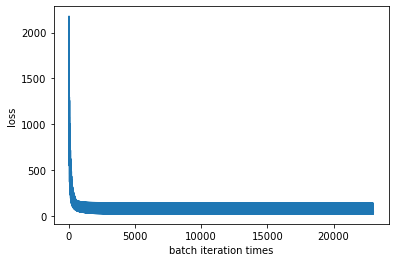

after 1000 iterations with the batch size 252 and learning rate 0.005000,the final loss is 46.79
117144177.8260352


In [274]:
main()